In [1]:
import os
import sys
import yaml
import torch
from gpytorch import kernels, distributions
import numpy as np
import matplotlib.pyplot as plt
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import src.preprocessing as preproc
from src.models import *

In [2]:
# Load config file
with open('../config/svgp.yaml', "r") as f:
    cfg = yaml.safe_load(f)
cfg['dataset']['path'] = '../data/aodisaggregation_emmisions_test_6.3_ACCMIP_200806.06_echam.nc'

# Load dataset
data = preproc.make_data(cfg=cfg, include_2d=False)

In [7]:
# Define kernel
time_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=1, active_dims=[0])
latlon_kernel = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[2, 3]))
P_relhum_kernel = kernels.ScaleKernel(kernels.MaternKernel(nu=0.5, ard_num_dims=2, active_dims=[4, 5]))
kernel = time_kernel * latlon_kernel + P_relhum_kernel

# Define aggregation operator
def trpz(grid):
    aggregated_grid = -torch.trapz(y=grid, x=data.h_by_column.unsqueeze(-1), dim=-2)
    return aggregated_grid

# Initialize inducing points regularly across grid
torch.random.manual_seed(cfg['model']['seed'])
lowaltitude_x_std = data.x_std[data.x_std[:, -1] < -0.8]
rdm_idx = torch.randperm(len(lowaltitude_x_std))[:cfg['model']['n_inducing_points']]
inducing_points = lowaltitude_x_std[rdm_idx]

# Initialize model
model = AggregateGammaSVGP(inducing_points=inducing_points,
                           transform=torch.exp,
                           kernel=kernel,
                           aggregate_fn=trpz,
                           fit_intercept=cfg['model']['fit_intercept'])

# Load state dict
state_dict = torch.load('../sandbox/outputs/dev/svgp/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
# Choose a random subset of 1000 points to evaluate model over
torch.random.manual_seed(5)
rdm_idx = torch.randperm(len(data.h_by_column_std))[:1000]

# Initialize empty tensors
prediction_3d_means = torch.zeros_like(data.h_by_column_std[rdm_idx])
prediction_3d_stddevs = torch.zeros_like(data.h_by_column_std[rdm_idx])
h_stddev = data.h_by_column.std()

# Setup index iteration and progress bar
indices = torch.arange(len(data.x_by_column_std[rdm_idx]))
n_samples = len(data.z[rdm_idx])
lbda = cfg['model']['lbda']
batch_size = cfg['evaluation']['batch_size']

with torch.no_grad():
    batch_iter = tqdm.notebook.tqdm(indices.split(batch_size))
    for idx in batch_iter:
        # Predict on standardized 3D covariates
        qf_by_column = model(data.x_by_column_std[idx])

        # Register in grid
        prediction_3d_means[idx] = qf_by_column.mean - lbda * data.h_by_column_std[idx]
        prediction_3d_stddevs[idx] = qf_by_column.stddev

    # Make up for height standardization in integration
    prediction_3d_means.sub_(torch.log(h_stddev))

    # Rescale predictions by τ/∫φdh
    def trpz(grid):
        aggregated_grid = -torch.trapz(y=grid, x=data.h_by_column[rdm_idx].unsqueeze(-1).cpu(), dim=-2)
        return aggregated_grid
    φ = torch.exp(prediction_3d_means + 0.5 * prediction_3d_stddevs.square())
    aggregate_prediction_2d = trpz(φ.unsqueeze(-1)).squeeze()
    correction = torch.log(data.z[rdm_idx]) - torch.log(aggregate_prediction_2d)
    prediction_3d_means.add_(correction.unsqueeze(-1))
    
    # Make distribution
    prediction_3d_dist = torch.distributions.LogNormal(prediction_3d_means, prediction_3d_stddevs)

In [9]:
# Compute calibration plots for given region sizes
def compute_calibrations(prediction_3d_dist, sizes):
    calibration = []
    mu = prediction_3d_dist.mean
    for size in sizes:
        q_lb = (1 - size) / 2
        q_ub = 1 - q_lb
        lb = prediction_3d_dist.icdf(torch.tensor(q_lb))
        ub = prediction_3d_dist.icdf(torch.tensor(q_ub))
        lb_mask = data.gt_by_column[rdm_idx] > lb
        ub_mask = data.gt_by_column[rdm_idx] < ub
        value_mask = data.gt_by_column[rdm_idx] > -1
        region_mask = lb_mask[value_mask] & ub_mask[value_mask]
        calibration.append(region_mask.float().mean().item())
    return np.asarray(calibration)

# Rescale distribution variance without shifting mean
def rescale_variance(prediction_3d_dist, variance_multiplier):
    mu0 = prediction_3d_dist.loc
    sigma0 = prediction_3d_dist.scale
    sigma1 = variance_multiplier * sigma0
    mu1 = mu0 + (sigma0.square() - sigma1.square()) / 2
    recalibrated_dist = torch.distributions.LogNormal(mu1, sigma1)
    return recalibrated_dist

# Compute deviation from perfect calibration
def calibration_integral(calibration, sizes):
    return np.abs(calibration - sizes).sum()

In [12]:
# Range of variance multipliers to look into
variance_multipliers = np.arange(1., 8.1, 0.1)
variance_iters = tqdm.notebook.tqdm(variance_multipliers)

# Confidence region sizes to consider
sizes = np.arange(0.01, 1., 0.01)

integrals = []
for variance_multiplier in variance_iters:
    recalibrated_dist = rescale_variance(prediction_3d_dist, variance_multiplier)
    calibration = compute_calibrations(recalibrated_dist, sizes)
    integrals.append(calibration_integral(calibration, sizes))
integrals = np.asarray(integrals)

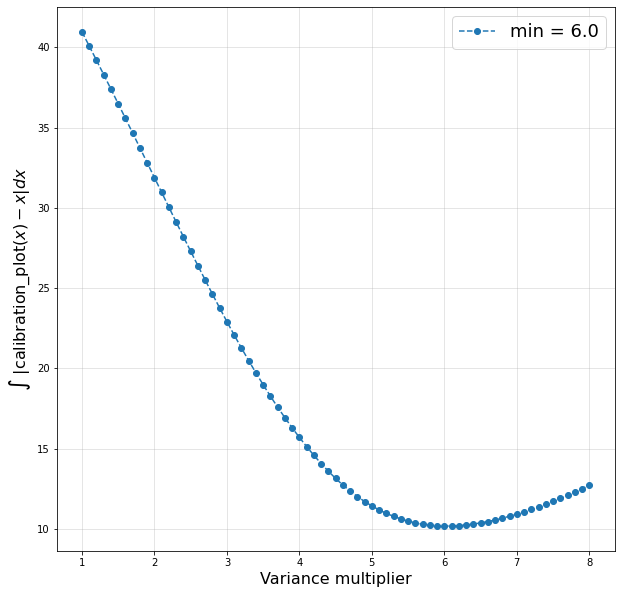

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

best_multiplier = variance_multipliers[np.argmin(integrals)]
ax.plot(variance_multipliers, integrals, '--o', label=f'min = {best_multiplier:.1f}')

ax.set_xlabel('Variance multiplier', fontsize=16)
ax.set_ylabel(r'$\int$ |calibration_plot$(x) - x|dx$ ', fontsize=16)
ax.grid(alpha=0.4)
plt.legend(fontsize=18)